In [64]:
import numpy as np
import pandas as pd 
import ROOT 

unfolded_spectra_names = ["unfolded_{}_Iteration{}".format(method,i) for method in ["area","mult","dnn","snn"] for i in range(2,9)]
unfolded_over_truth_names = ["{}_unfolded_over_truth_Iteration{}".format(method,i) for method in ["area","mult","dnn","snn"] for i in range(2,9)]
pearson_matrix_names = ["{}_pearson_Iteration{}".format(method,i) for method in ["area","mult","dnn","snn"] for i in range(2,9)]
covariance_matrix_names = ["{}_covariance_Iteration{}".format(method,i) for method in ["area","mult","dnn","snn"] for i in range(2,9)]
measurement_over_truth_names = ["{}_measurement_over_truth".format(method) for method in ['area','mult','dnn','snn']]
area_measurement_over_truth_normalized_names = ["{}_measurement_over_truth_normalized".format(method) for method in ['area','mult','dnn','snn']]
measurement_names = ["measurement_{}_reco".format(method) for method in ['area','mult','dnn','snn']]
truth_name = ["h_truth"]
TH2D_names = pearson_matrix_names+covariance_matrix_names
TH1D_names = unfolded_spectra_names + unfolded_over_truth_names + measurement_over_truth_names + measurement_names + truth_name + area_measurement_over_truth_normalized_names

def TH1toMatplot(hist):
    x = np.array([hist.GetBinCenter(i) for i in range(1,hist.GetNbinsX()+1)])
    x_err = np.array([hist.GetBinWidth(i)/2 for i in range(1,hist.GetNbinsX()+1)])
    y = np.array([hist.GetBinContent(i) for i in range(1,hist.GetNbinsX()+1)])
    y_err = np.array([hist.GetBinError(i) for i in range(1,hist.GetNbinsX()+1)])
    return [x,x_err],[y,y_err]

def GetHistoDictionary(datasets=["AuAu_R02","AuAu_R04","AuAu_R06","PbPb_R02","PbPb_R04","PbPb_R06"],
                       filebase= '/lustre/isaac/scratch/tmengel/jet-background-subtraction/unfold/results/'
                       ):
    histos = {}
    for ds in datasets:
        filename = filebase + '{}/unfolding_output.root'.format(ds)
        file = ROOT.TFile(filename)
        
        th1ds = {}
        for name in TH1D_names:
            # print(name)
            th1d = file.Get(name)
            x = np.array([th1d.GetBinCenter(i) for i in range(1,th1d.GetNbinsX()+1)])
            x_err = np.array([th1d.GetBinWidth(i)/2 for i in range(1,th1d.GetNbinsX()+1)])
            y = np.array([th1d.GetBinContent(i) for i in range(1,th1d.GetNbinsX()+1)])
            y_err = np.array([th1d.GetBinError(i) for i in range(1,th1d.GetNbinsX()+1)])
            X = [x,x_err]
            Y = [y,y_err]
            th1ds[name] = {'x': X[0], 'x_err': X[1], 'y': Y[0], 'y_err': Y[1]}
            
        th2ds = {}
        for name in TH2D_names:
            th2d = file.Get(name)
            xbins = np.array([th2d.GetXaxis().GetBinLowEdge(i) for i in range(1,th2d.GetNbinsX()+1)])
            ybins = np.array([th2d.GetYaxis().GetBinLowEdge(i) for i in range(1,th2d.GetNbinsY()+1)])
            values = []
            value_errors = []
            for i in range(1,th2d.GetNbinsX()+1):
                tmpvalues = []
                tmpvalue_errors = []
                for j in range(1,th2d.GetNbinsY()+1):
                    tmpvalues.append(th2d.GetBinContent(i,j))
                    tmpvalue_errors.append(th2d.GetBinError(i,j))
                values.append(tmpvalues)
                value_errors.append(tmpvalue_errors)
            values = np.array(values)
            value_errors = np.array(value_errors)  
            # values = np.array([th2d.GetBinContent(i,j) for i in range(1,th2d.GetNbinsX()+1) for j in range(1,th2d.GetNbinsY()+1)])
            # value_errors = np.array([th2d.GetBinError(i,j) for i in range(1,th2d.GetNbinsX()+1) for j in range(1,th2d.GetNbinsY()+1)])
            th2ds[name] = {'xbins': xbins, 'ybins': ybins, 'values': values, 'value_errors': value_errors}
            
        histos[ds] = {'th1ds': th1ds, 'th2ds': th2ds}
        
    return histos

def GetChi2Dictionary(datasets=["AuAu_R02","AuAu_R04","AuAu_R06","PbPb_R02","PbPb_R04","PbPb_R06"],
                       filebase= '/lustre/isaac/scratch/tmengel/jet-background-subtraction/unfold/results/'
                       ):
    chi2s = {}
    for ds in datasets:
        filename = filebase + '{}/unfolding_output.root'.format(ds)
        rdf = ROOT.RDataFrame("tree",filename).AsNumpy()
        chi2s_ds = {}
        for key in rdf.keys():
            chi2s_ds[key] = rdf[key]
        chi2s[ds] = chi2s_ds
    return chi2s
        
chi2 = GetChi2Dictionary()   
histograms = GetHistoDictionary() 

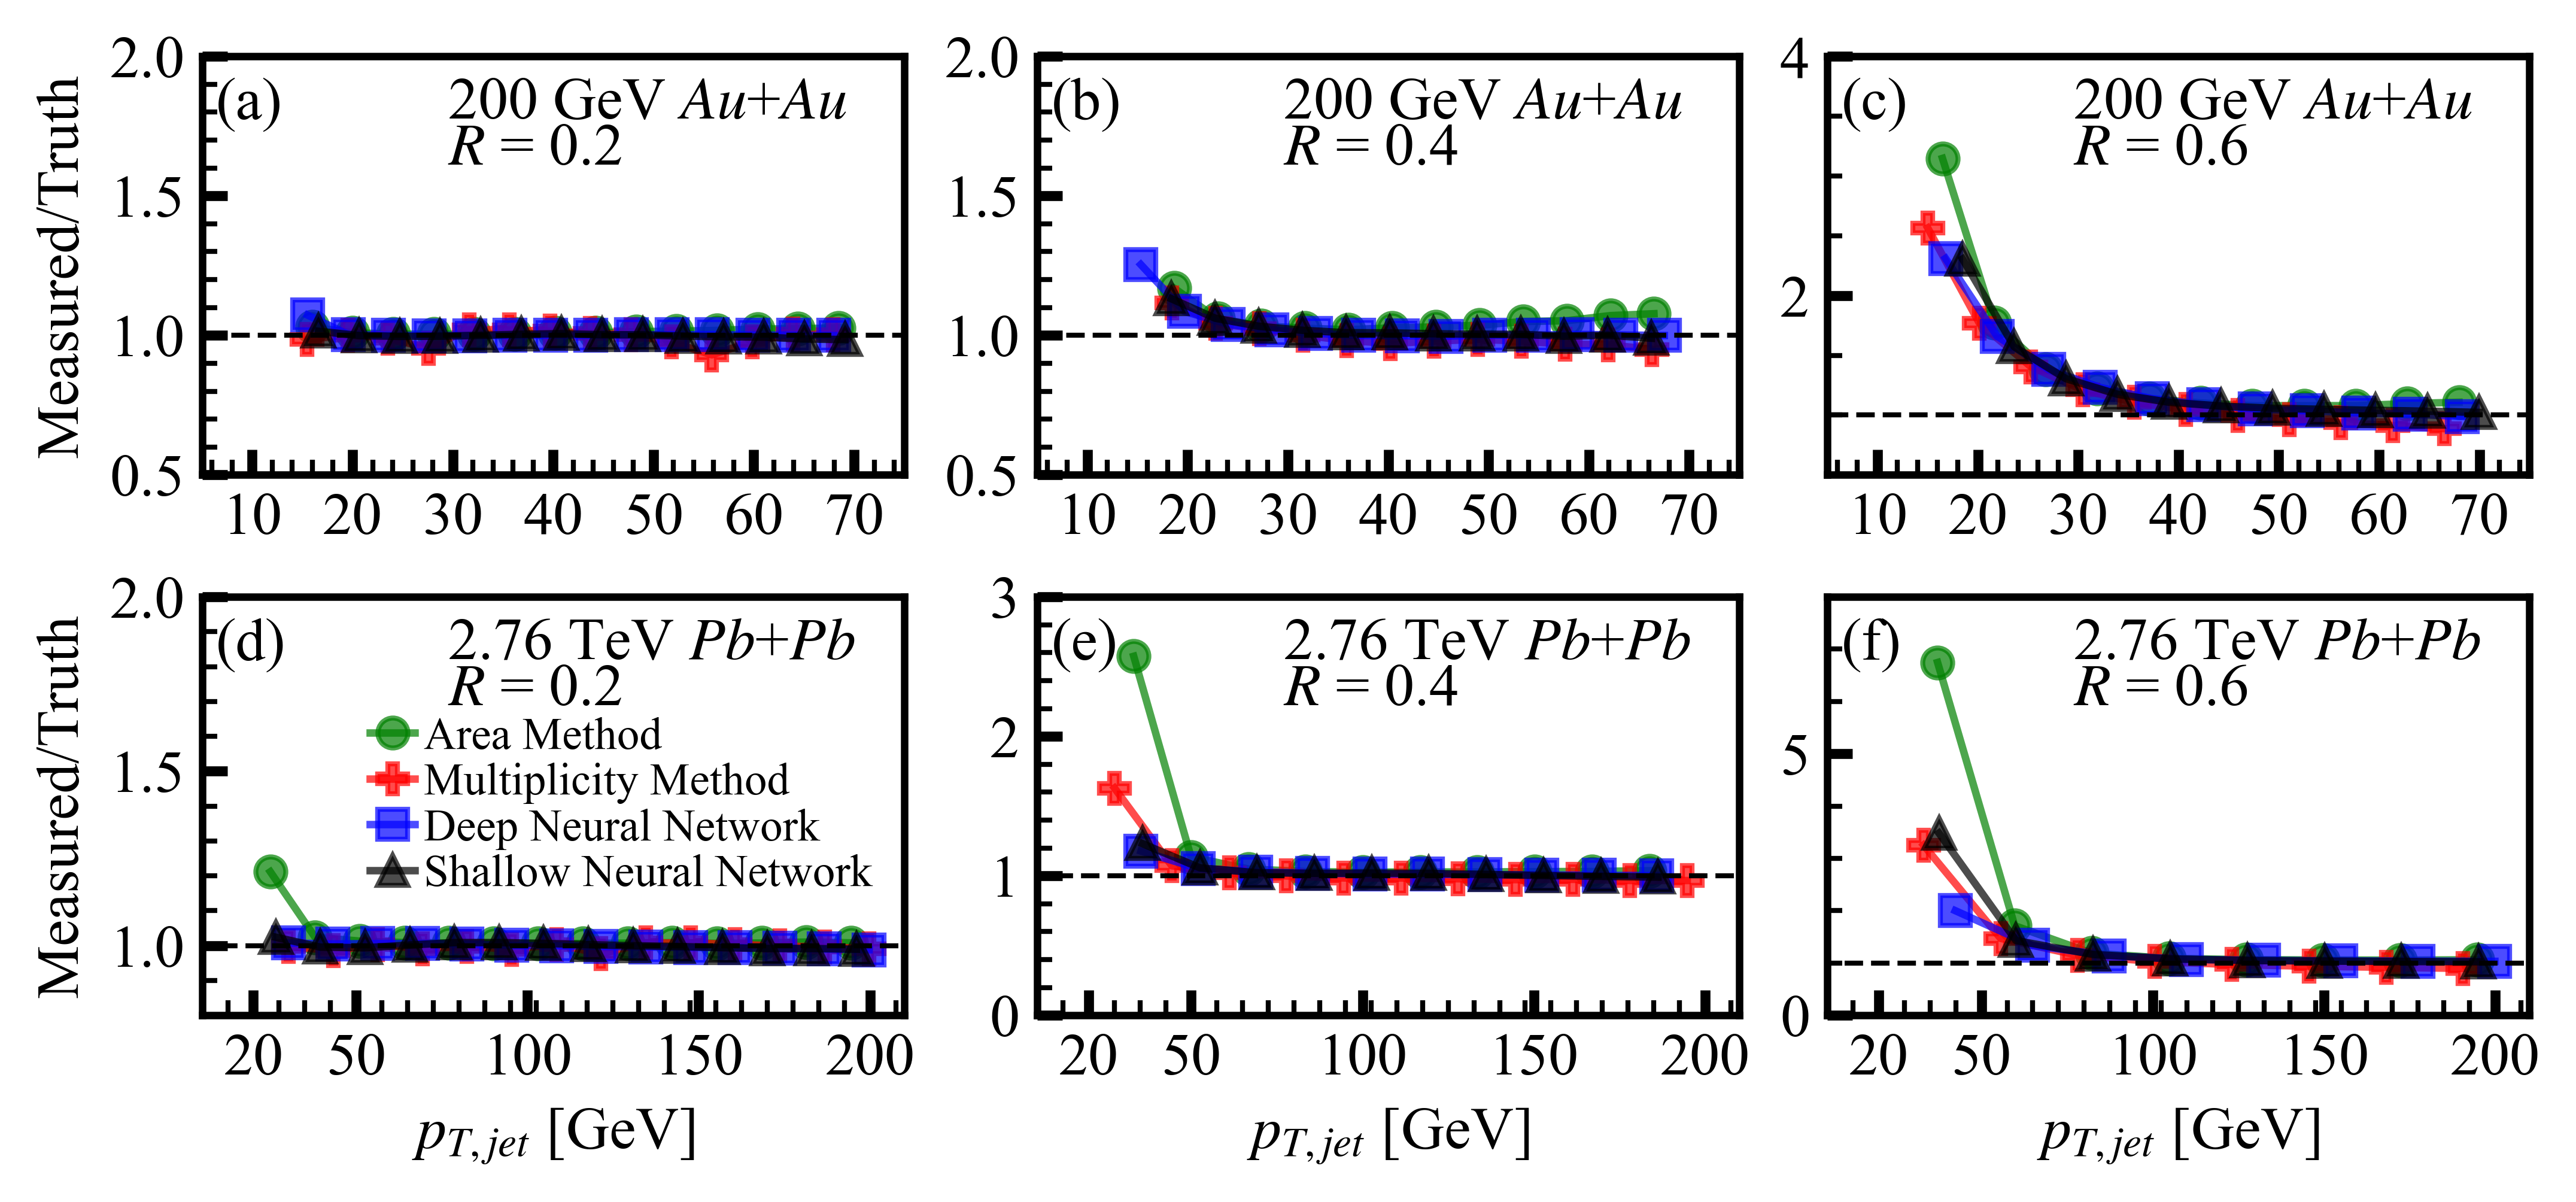

In [89]:
import paperstyle as ps
import matplotlib.pyplot as plt

fig_size = ps.GetFigSize(510.0, 2.7)
plt.rcParams.update(ps.style)
plt.rcParams.update({'figure.figsize': fig_size})

# area_style = ps.area
# dnn_style = ps.dnn
# mult_style = ps.mult
# snn_style = ps.snn

area_style = dict(color='green', marker='o', markerfacecolor='green', markeredgecolor='green', alpha=0.7, label='Area Method')
dnn_style = dict(color='blue',  marker='s', markerfacecolor='blue', markeredgecolor='blue', alpha=0.7, label='Deep Neural Network')
mult_style = dict(color='red',  marker='P', markerfacecolor='red', markeredgecolor='red', alpha=0.7, label='Multiplicity Method')
snn_style = dict(color='black',  marker='^', markerfacecolor='black', markeredgecolor='black', alpha=0.7, label='Shallow Neural Network')

styles= [area_style, mult_style, dnn_style, snn_style]


fig ,axs = plt.subplots(2, 3, dpi=600, constrained_layout=True)


datasets = ["AuAu_R02", "AuAu_R04", "AuAu_R06", "PbPb_R02", "PbPb_R04", "PbPb_R06"]
labels = [r'(a)', r'(b)', r'(c)', r'(d)', r'(e)', r'(f)']
species = [r'200 GeV $Au$+$Au$', r'200 GeV $Au$+$Au$', r'200 GeV $Au$+$Au$', r'2.76 TeV $Pb$+$Pb$', r'2.76 TeV $Pb$+$Pb$', r'2.76 TeV $Pb$+$Pb$']
radii = [r'$R$ = 0.2', r'$R$ = 0.4', r'$R$ = 0.6', r'$R$ = 0.2', r'$R$ = 0.4', r'$R$ = 0.6']

# plotted_histos = ['{}_unfolded_over_truth_Iteration{}'.format(method,8) for method in ['area','dnn','mult','snn']]
plotted_histos=['{}_measurement_over_truth'.format(method) for method in ['area','mult', 'dnn', 'snn']]

for i, dataset in enumerate(datasets):
        ax = axs[i//3, i%3]
        if i < 3:
                pass
                # ax.tick_params(labelbottom=False)               
        else:
            ax.set_xlabel(r"$p_{T,jet}$ [GeV]")
        
        if i == 0 or i == 3:
            ax.set_ylabel(r"Measured/Truth")
            
        if i > 2:
            stop_val = 200
        else:
            stop_val = 70
            
        if i >2:
            start_val = 23
        else:
            start_val = 15
        
        if i ==5:
            start_val = 9
            
        
        
        y_cut = 10.0
        
        for plotted_histo in plotted_histos:
            if plotted_histo.split('_')[0] == 'area':
                style = area_style
            elif plotted_histo.split('_')[0] == 'mult':
                style = mult_style
            elif plotted_histo.split('_')[0] == 'dnn':
                style = dnn_style
            elif plotted_histo.split('_')[0] == 'snn':
                style = snn_style
        
            histox = histograms[dataset]['th1ds'][plotted_histo]['x'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histoy = histograms[dataset]['th1ds'][plotted_histo]['y'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histox_err = histograms[dataset]['th1ds'][plotted_histo]['x_err'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histoy_err = histograms[dataset]['th1ds'][plotted_histo]['y_err'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
        
            histoxc = histox[histox >= start_val]
            histoyc = histoy[histox >= start_val]
            histox_errc = histox_err[histox >= start_val]
            histoy_errc = histoy_err[histox >= start_val]
            
            idx_to_plot = np.where(histoyc < y_cut)
            histoyc = histoyc[idx_to_plot]
            histoxc = histoxc[idx_to_plot]
            histox_errc = histox_errc[idx_to_plot]
            histoy_errc = histoy_errc[idx_to_plot]
            histoy_errc=np.zeros_like(histoyc)
            # ax.errorbar(histoxc, histoyc, xerr=histox_errc, yerr=histoy_errc, **style, linestyle='-')
            ax.plot(histoxc, histoyc, **style, linestyle='-', linewidth=1.5)
        
        ax.text(0.02, 0.95, labels[i], transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.text(0.35, 0.95, f'{species[i]}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.text(0.35, 0.84, radii[i], transform=ax.transAxes, fontsize=12, verticalalignment='top')
        # ax.set_ylim(0.8, 10.0)
        # ax.set_xscale('symlog')
        # ax.set_yscale('log')
        # ax.set_ylim(0.8, 5.0)
        if i <3:
            ax.plot([0, 100], [1, 1], 'k--')
            ax.set_xlim(5, 75)
            ax.set_xticks([10, 20, 30, 40, 50, 60, 70])
        else:
            ax.plot([10, 210], [1, 1], 'k--')
            ax.set_xlim(5, 210)
            ax.set_xticks([20, 50, 100, 150, 200])
        
        if i == 0:
            # ax.set_xlim(8, 72)
            ax.set_ylim(0.5, 2.0)
        elif i == 1:
            # ax.set_xlim(8, 72)
            ax.set_ylim(0.5, 2.0)
        elif i == 2:
            # ax.set_xlim(8, 72)
            ax.set_ylim(0.5, 4.0)
        elif i == 3:
            # ax.set_xlim(18, 112)
            ax.set_ylim(0.8, 2.0)
        elif i == 4:
            # ax.set_xlim(18, 112)
            ax.set_ylim(0.0, 3.0)
        elif i ==5:
            # ax.set_xlim(18, 112)
            ax.set_ylim(0.0, 8.0)

        if i ==3:
            ax.legend(loc='center right', fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.2, borderpad=0.2, handlelength=1.0, ncol=1, columnspacing=0.3)

fig.align_ylabels()

fig.savefig("pdf/measured_over_truth.pdf", bbox_inches='tight')
fig.savefig("png/measured_over_truth.png", bbox_inches='tight')
plt.show()


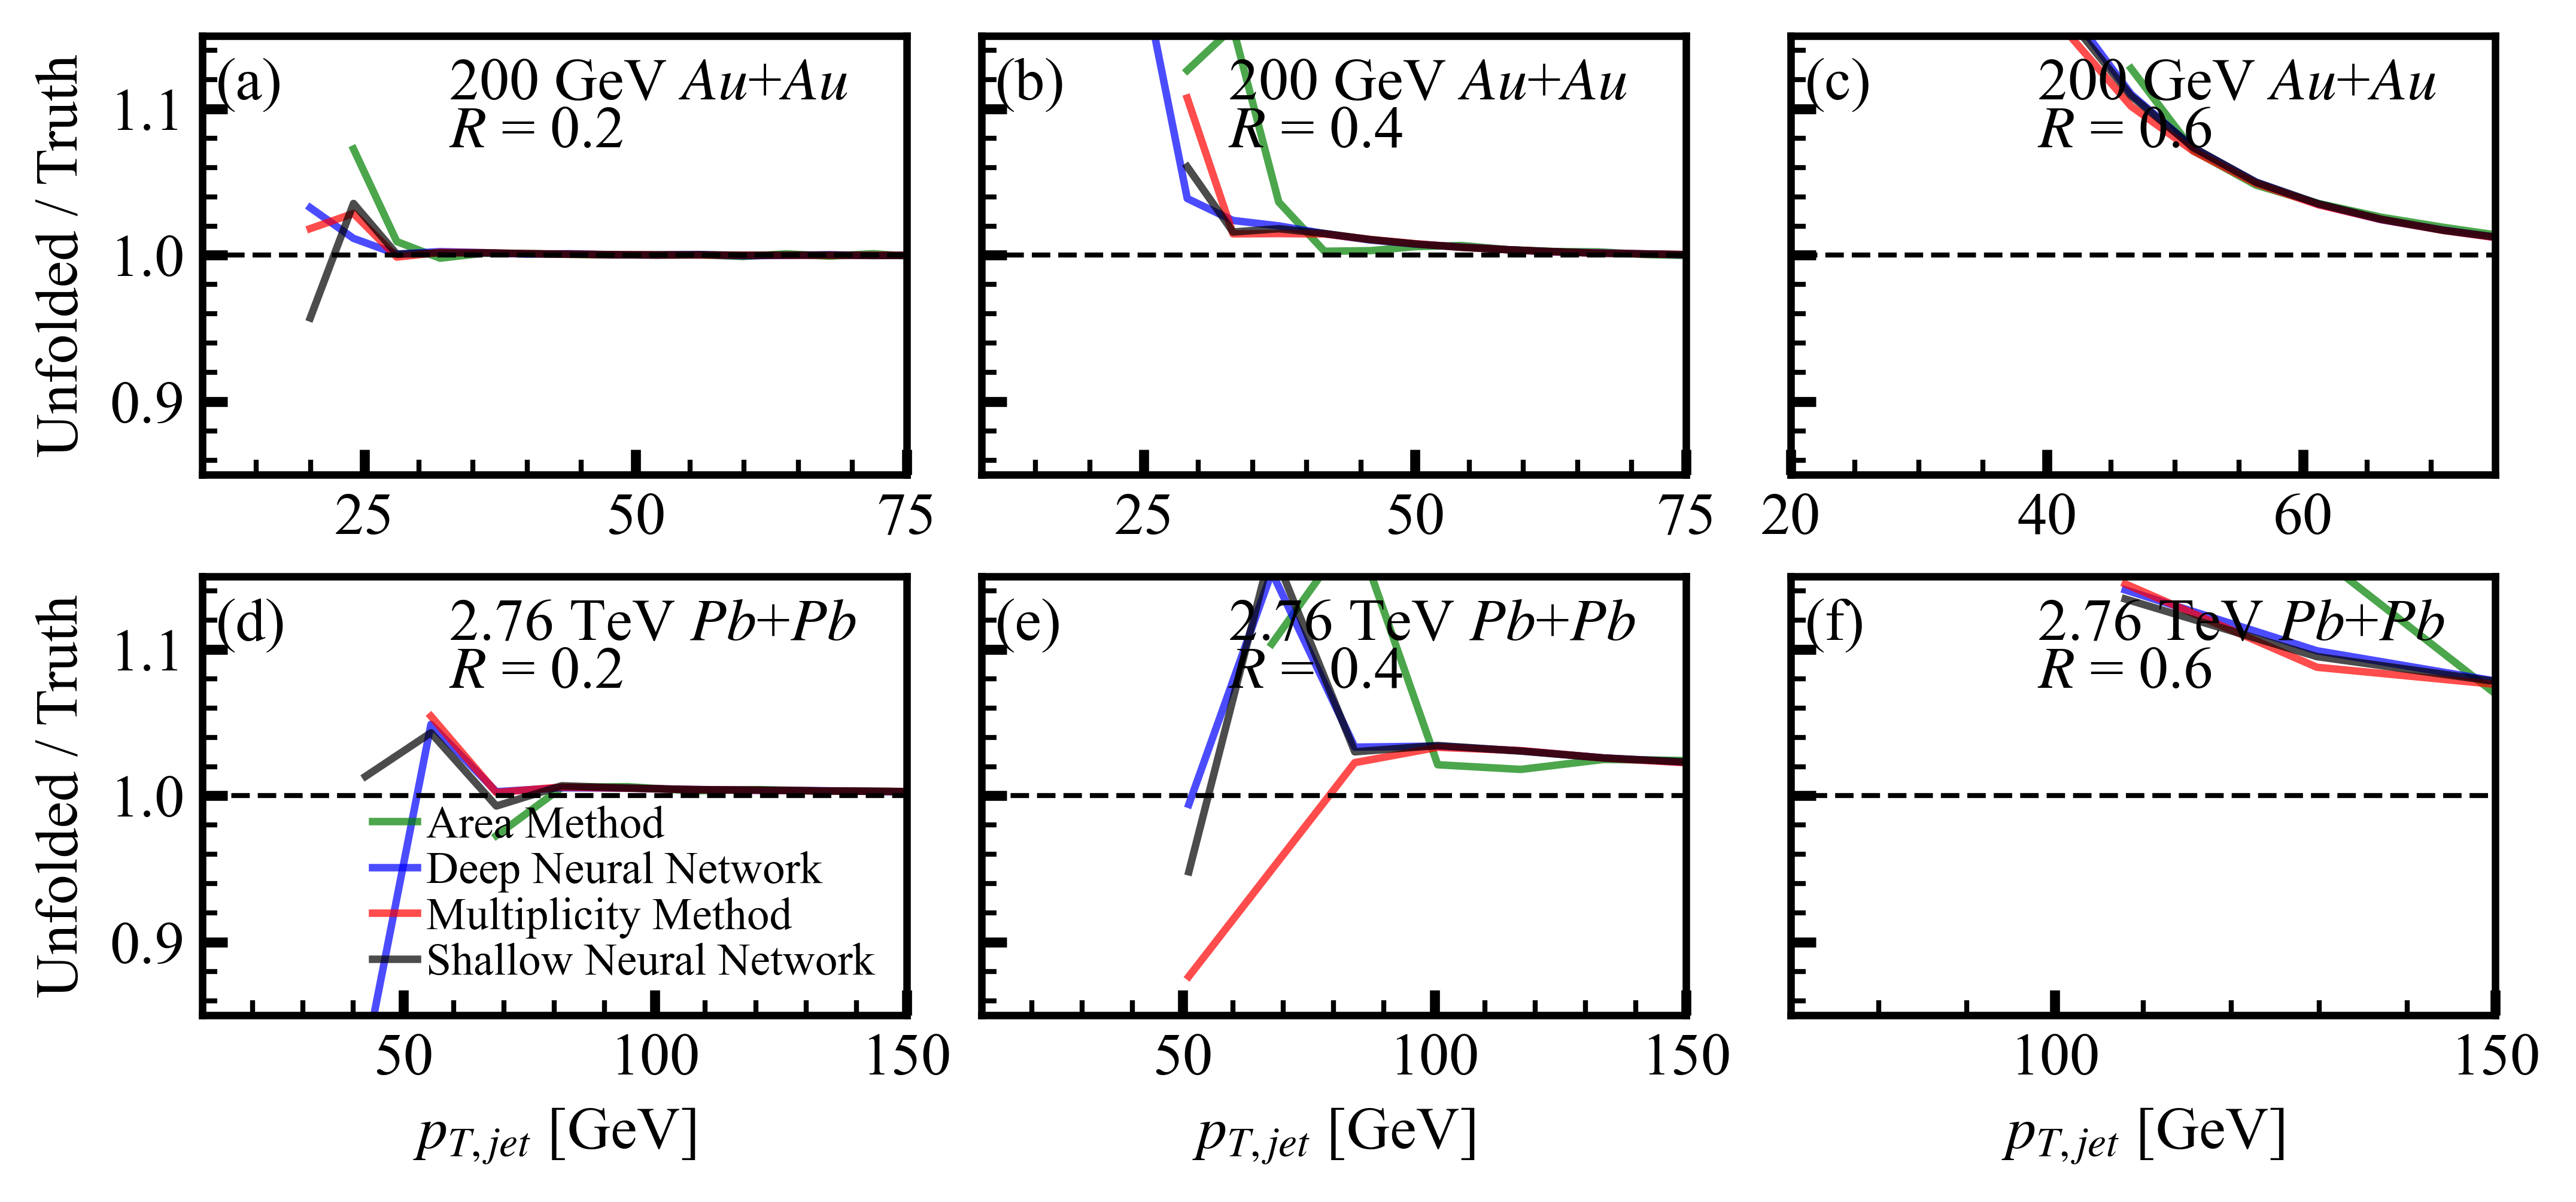

In [9]:
import paperstyle as ps
import matplotlib.pyplot as plt

fig_size = ps.GetFigSize(510.0, 2.7)
plt.rcParams.update(ps.style)
plt.rcParams.update({'figure.figsize': fig_size})

area_style = ps.area
dnn_style = ps.dnn
mult_style = ps.mult
snn_style = ps.snn
styles= [area_style, mult_style, dnn_style, snn_style]

area_style = dict(color='green', marker=' ', markerfacecolor='green', markeredgecolor='green', alpha=0.7, label='Area Method', markersize=4)
dnn_style = dict(color='blue',  marker=' ', markerfacecolor='blue', markeredgecolor='blue', alpha=0.7, label='Deep Neural Network', markersize=4)
mult_style = dict(color='red',  marker=' ', markerfacecolor='red', markeredgecolor='red', alpha=0.7, label='Multiplicity Method', markersize=4)
snn_style = dict(color='black',  marker=' ', markerfacecolor='black', markeredgecolor='black', alpha=0.7, label='Shallow Neural Network', markersize=4)

fig ,axs = plt.subplots(2, 3, dpi=600, constrained_layout=True, sharey=True)


datasets = ["AuAu_R02", "AuAu_R04", "AuAu_R06", "PbPb_R02", "PbPb_R04", "PbPb_R06"]
labels = [r'(a)', r'(b)', r'(c)', r'(d)', r'(e)', r'(f)']
species = [r'200 GeV $Au$+$Au$', r'200 GeV $Au$+$Au$', r'200 GeV $Au$+$Au$', r'2.76 TeV $Pb$+$Pb$', r'2.76 TeV $Pb$+$Pb$', r'2.76 TeV $Pb$+$Pb$']
radii = [r'$R$ = 0.2', r'$R$ = 0.4', r'$R$ = 0.6', r'$R$ = 0.2', r'$R$ = 0.4', r'$R$ = 0.6']

plotted_histos = ['{}_unfolded_over_truth_Iteration{}'.format(method,5) for method in ['area','dnn','mult','snn']]
# plotted_histos = ['{}_unfolded_over_truth_Iteration{}'.format(method,5) for method in ['area','mult']]
# plotted_histos=['{}_measurement_over_truth_normalized'.format(method) for method in ['area','mult', 'dnn', 'snn']]

for i, dataset in enumerate(datasets):
        ax = axs[i//3, i%3]
        if i < 3:
                pass
                # ax.tick_params(labelbottom=False)               
        else:
            ax.set_xlabel(r"$p_{T,jet}$ [GeV]")
        
        if i == 0 or i == 3:
            ax.set_ylabel(r"Unfolded / Truth")
            
        if i > 2:
            stop_val = 295
        else:
            stop_val = 100
        
        if i == 0:
            start_val = 17
        elif i == 1:
            start_val = 21
        elif i == 2:
            start_val = 35
        elif i == 3:
            start_val = 35
        elif i == 4:
            start_val = 35
        elif i == 5:
            start_val = 91
            
      
        
        
        y_cut = 0.2
        
        for plotted_histo in plotted_histos:
            if plotted_histo.split('_')[0] == 'area':
                style = area_style
            elif plotted_histo.split('_')[0] == 'mult':
                style = mult_style
            elif plotted_histo.split('_')[0] == 'dnn':
                style = dnn_style
            elif plotted_histo.split('_')[0] == 'snn':
                style = snn_style
        
            histox = histograms[dataset]['th1ds'][plotted_histo]['x'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histoy = histograms[dataset]['th1ds'][plotted_histo]['y'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histox_err = histograms[dataset]['th1ds'][plotted_histo]['x_err'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histoy_err = histograms[dataset]['th1ds'][plotted_histo]['y_err'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
        
            histoxc = histox[histox >= start_val]
            histoyc = histoy[histox >= start_val]
            histox_errc = histox_err[histox >= start_val]
            histoy_errc = histoy_err[histox >= start_val]
            
            idx_to_plot = np.where(np.abs(histoyc-1.0) < y_cut)
            histoyc = histoyc[idx_to_plot]
            histoxc = histoxc[idx_to_plot]
            histox_errc = histox_errc[idx_to_plot]
            histoy_errc = histoy_errc[idx_to_plot]
            histoy_errc=np.zeros_like(histoyc)
            # ax.errorbar(histoxc, histoyc, xerr=histox_errc, yerr=histoy_errc, **style, linestyle=' ')
            ax.plot(histoxc, histoyc, **style, linestyle='-', linewidth=1.5)
        
        
        ax.text(0.02, 0.95, labels[i], transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.text(0.35, 0.95, f'{species[i]}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.text(0.35, 0.84, radii[i], transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.set_ylim(0.85, 1.15)
        # ax.set_yscale('log')
        ax.plot([0, 300], [1, 1], 'k--')
        
        if i < 2:
            ax.set_xlim(10, 75)
        else:
            ax.set_xlim(10, 150)
        
        if i == 5:
            ax.set_xlim(70, 150)
        if i == 2:
            ax.set_xlim(20, 75)
        if i ==3:
            ax.legend(loc='lower right', fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.2, borderpad=0.2, handlelength=1.0, ncol=1, columnspacing=0.3)

fig.align_ylabels()

fig.savefig("pdf/Unfolded_over_truth.pdf", bbox_inches='tight')
fig.savefig("png/Unfolded_over_truth.png", bbox_inches='tight')
plt.show()


58.75980577970806 58.75980577970806 56.321815490722656
205.9546574773015 205.9546574773015 195.06828761745143


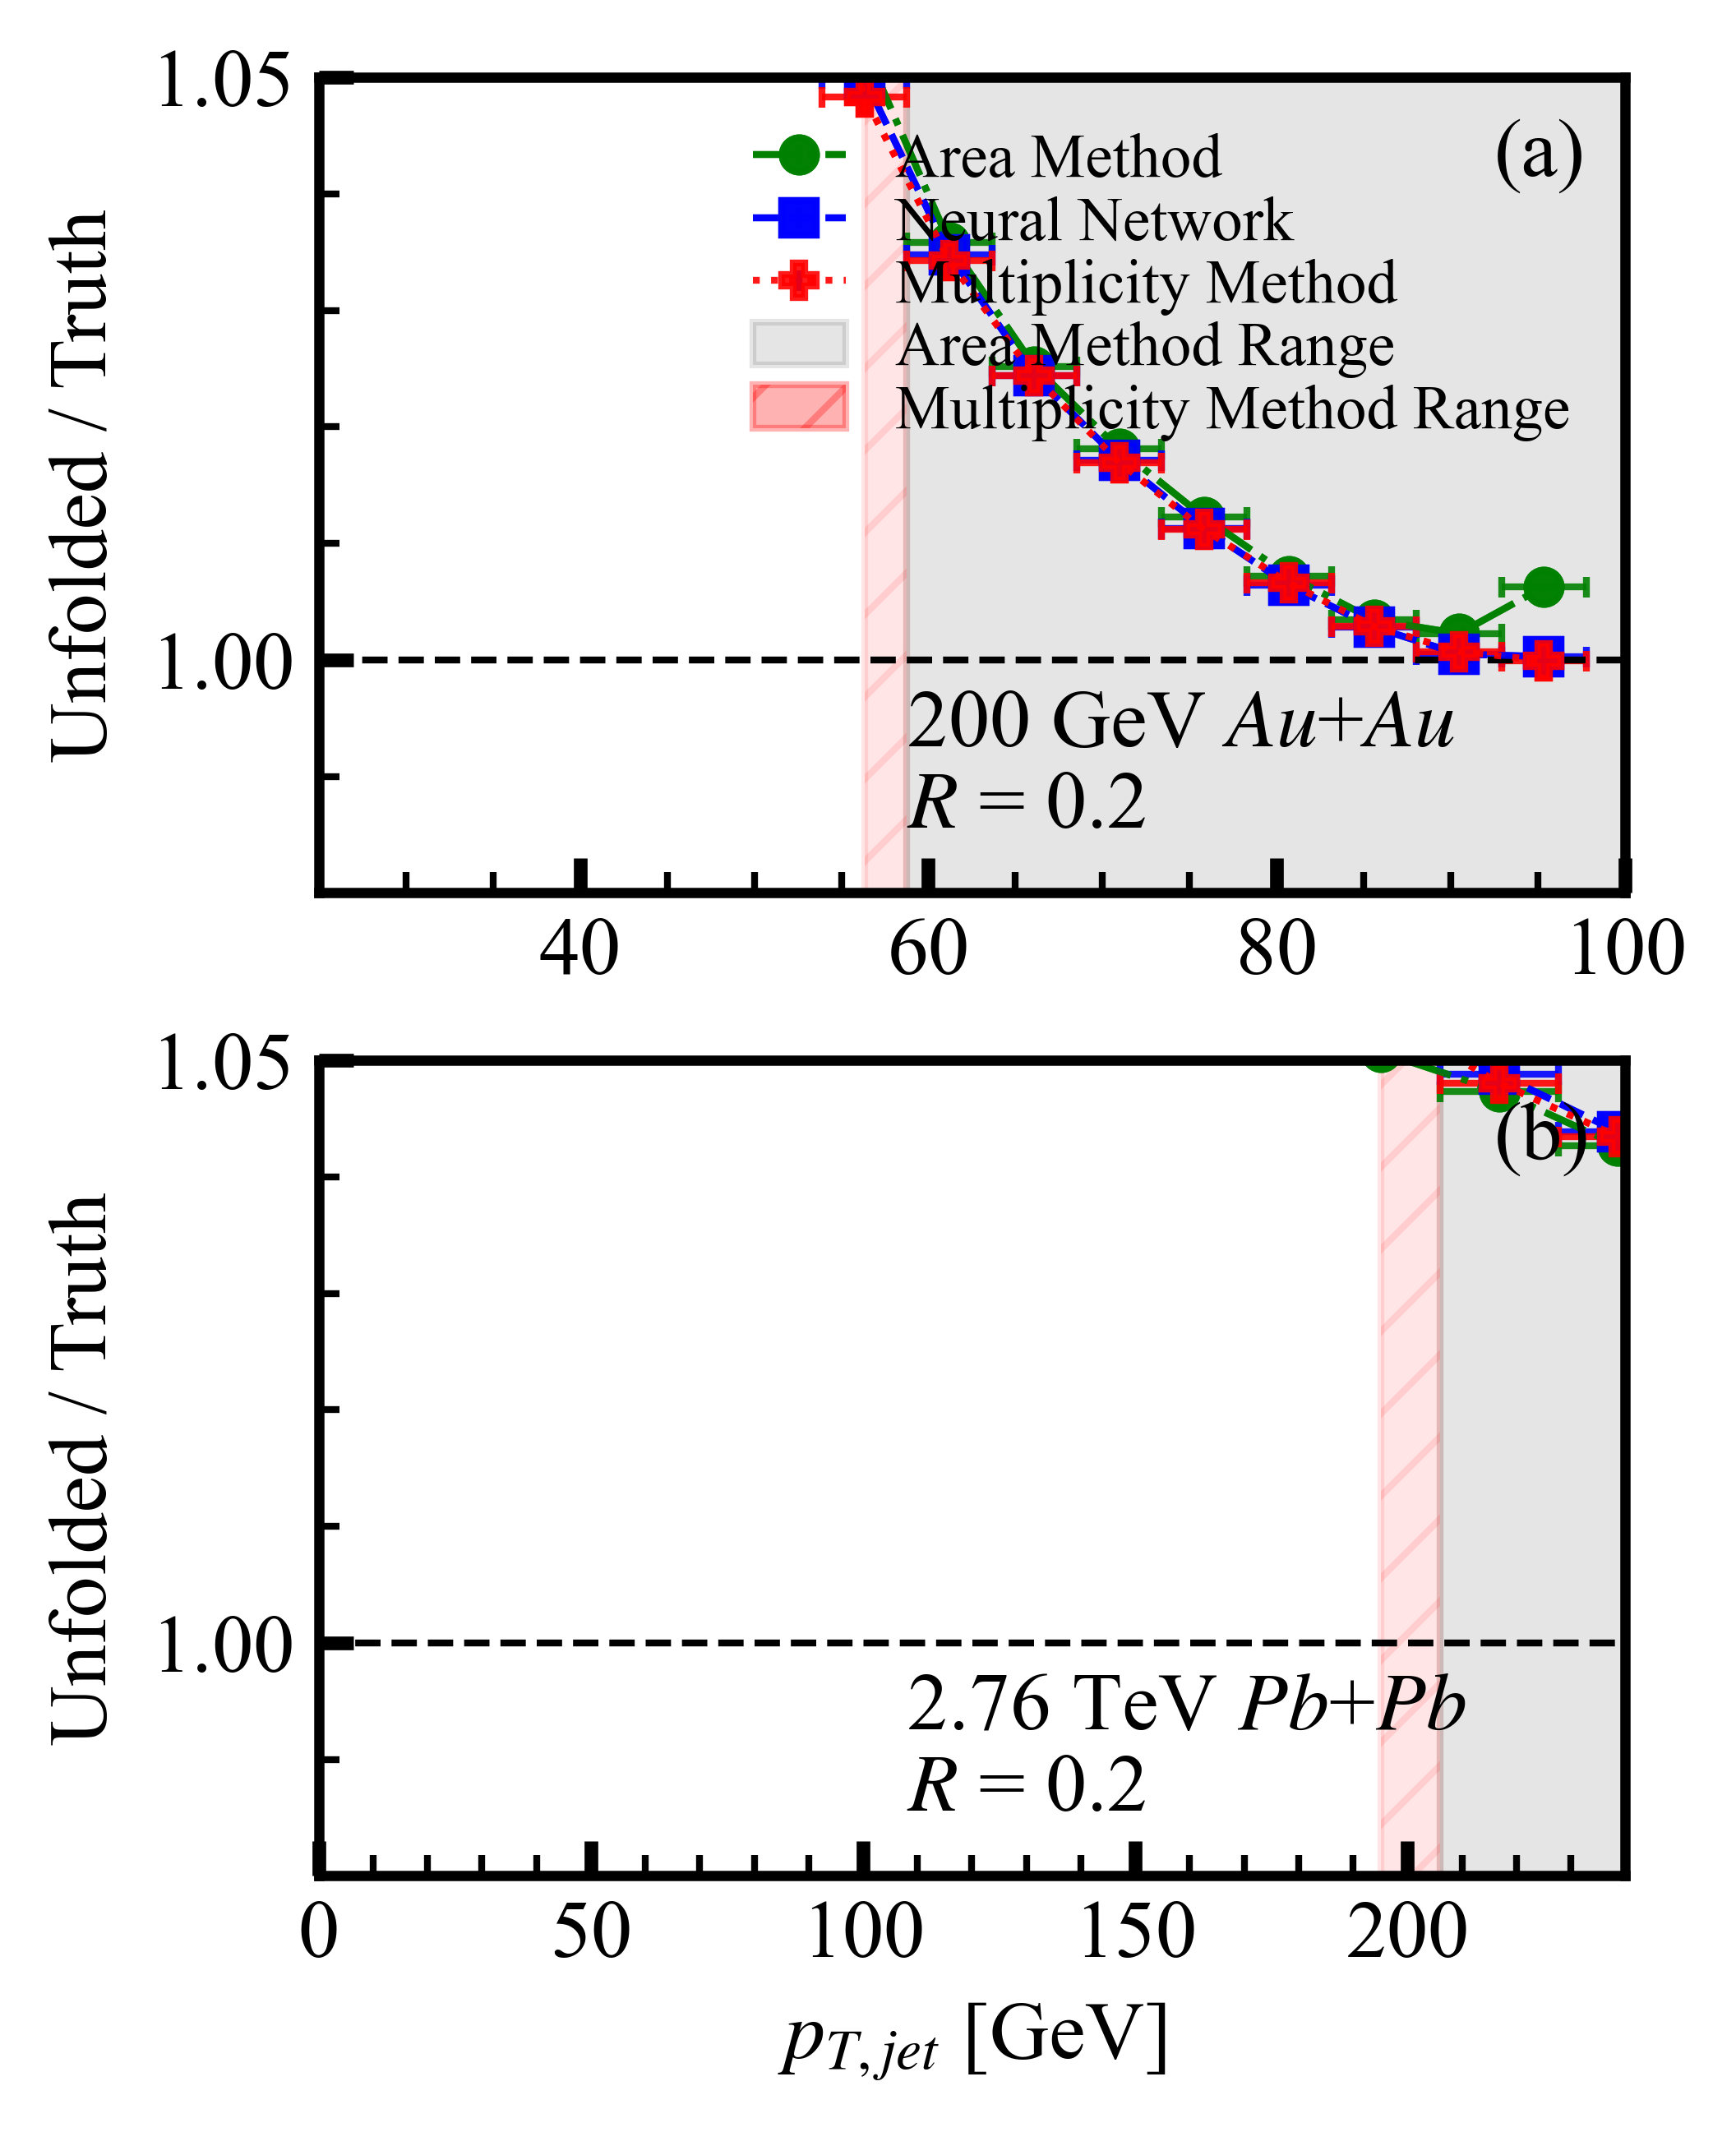

In [273]:
import paperstyle as ps
import matplotlib.pyplot as plt

fig_size = ps.GetFigSize(246.0, 1.0)
plt.rcParams.update(ps.style)
plt.rcParams.update({'figure.figsize': fig_size})

area_style = ps.area
dnn_style = ps.dnn
mult_style = ps.mult
snn_style = ps.snn
styles= [area_style, mult_style, dnn_style, snn_style]

area_style = dict(color='green', marker='o', markerfacecolor='green', markeredgecolor='green', alpha=0.9, label='Area Method', markersize=5,linestyle="-.", linewidth=1.0)
dnn_style = dict(color='blue',  marker='s', markerfacecolor='blue', markeredgecolor='blue', alpha=0.9, label='Neural Network', markersize=5,linestyle="--", linewidth=1.0)
mult_style = dict(color='red',  marker='P', markerfacecolor='red', markeredgecolor='red', alpha=0.9, label='Multiplicity Method', markersize=5,linestyle=":", linewidth=1.0)
# snn_style = dict(color='black',  marker=' ', markerfacecolor='black', markeredgecolor='black', alpha=0.7, label='Shallow Neural Network', markersize=4)

fig ,axs = plt.subplots(2, 1, dpi=600, constrained_layout=True)


datasets = [ "AuAu_R06", "PbPb_R06"]
labels = [r'(a)', r'(b)']
species = [r'200 GeV $Au$+$Au$', r'2.76 TeV $Pb$+$Pb$']
radii = [r'$R$ = 0.2', r'$R$ = 0.2']

plotted_histos = ['{}_unfolded_over_truth_Iteration{}'.format(method,4) for method in ['area','dnn','mult']]
# plotted_histos = ['{}_unfolded_over_truth_Iteration{}'.format(method,5) for method in ['area','mult']]
# plotted_histos=['{}_measurement_over_truth_normalized'.format(method) for method in ['area','mult', 'dnn', 'snn']]



for i, dataset in enumerate(datasets):
        ax = axs[i%2]            
        if i == 1:
            ax.set_xlabel(r"$p_{T,jet}$ [GeV]")
        
        if i == 0 or i == 1:
            # pass
            ax.set_ylabel(r"Unfolded / Truth")
            
        if i == 1:
            stop_val = 249
        elif i == 0:
            stop_val = 100
        
        if i == 0:
            start_val = 0
        elif i == 1:
            start_val = 0
            
        y_cut = 1.0
        
        
        for plotted_histo in plotted_histos:
            if plotted_histo.split('_')[0] == 'area':
                style = area_style
            elif plotted_histo.split('_')[0] == 'mult':
                style = mult_style
            elif plotted_histo.split('_')[0] == 'dnn':
                style = dnn_style
                
            histox = histograms[dataset]['th1ds'][plotted_histo]['x'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histoy = histograms[dataset]['th1ds'][plotted_histo]['y'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histox_err = histograms[dataset]['th1ds'][plotted_histo]['x_err'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
            histoy_err = histograms[dataset]['th1ds'][plotted_histo]['y_err'][histograms[dataset]['th1ds'][plotted_histo]['x'] < stop_val]
        
            histoxc = histox[histox >= start_val]
            histoyc = histoy[histox >= start_val]
            histox_errc = histox_err[histox >= start_val]
            histoy_errc = histoy_err[histox >= start_val]
            
            idx_to_plot = np.where(np.abs(histoyc-1.0) < y_cut)
            histoyc = histoyc[idx_to_plot]
            histoxc = histoxc[idx_to_plot]
            histox_errc = histox_errc[idx_to_plot]
            histoy_errc = histoy_errc[idx_to_plot]
            # histoy_errc=np.zeros_like(histoyc)
            
            #find max value
            max_val = np.argmax(histoyc)
            
            histoxc = histoxc[max_val:]
            histoyc = histoyc[max_val:]
            histox_errc = histox_errc[max_val:]
            histoy_errc = histoy_errc[max_val:]
            
            ax.plot(histoxc, histoyc, **style)
            ax.errorbar(histoxc, histoyc, xerr=histox_errc, **style)
            # ax.plot(histoxc, histoyc, **style)
        
        # print(len(ax.lines))
        # print(ax.lines[0].get_xdata())
        # # print(ax.lines[0].get_ydata())
        # print(ax.lines[1].get_xdata())
        # # print(ax.lines[1].get_ydata())
        # print(ax.lines[2].get_xdata())
        # print(ax.lines[2].get_ydata())
        area_y_greater_than_threshold = np.max(np.where(ax.lines[0].get_ydata() > 1.05)[0])
        dnn_y_greater_than_threshold = np.max(np.where(ax.lines[1].get_ydata() > 1.05)[0])
        mult_y_greater_than_threshold = np.max(np.where(ax.lines[2].get_ydata() > 1.05)[0])
        
        if i == 0:
            # area_xvalue = 39.53643290201822 
            # dnn_xvalue = 31.09745207287016
            # mult_xvalue = 31.09745207287016
            area_xvalue = ax.lines[0].get_xdata()[area_y_greater_than_threshold+1] - histograms[dataset]['th1ds'][plotted_histos[0]]['x_err'][area_y_greater_than_threshold]
            dnn_xvalue = ax.lines[1].get_xdata()[dnn_y_greater_than_threshold+1] - histograms[dataset]['th1ds'][plotted_histos[1]]['x_err'][dnn_y_greater_than_threshold]
            mult_xvalue = ax.lines[2].get_xdata()[mult_y_greater_than_threshold+1] - histograms[dataset]['th1ds'][plotted_histos[2]]['x_err'][mult_y_greater_than_threshold]
        elif i == 1:
            # 92.42654605787627 75.94123684630102 75.94123684630102
            # area_xvalue = 92.42654605787627
            # dnn_xvalue = 75.94123684630102
            # mult_xvalue = 75.94123684630102
            
            area_xvalue = ax.lines[0].get_xdata()[area_y_greater_than_threshold+1] - histograms[dataset]['th1ds'][plotted_histos[0]]['x_err'][area_y_greater_than_threshold]
            dnn_xvalue = ax.lines[1].get_xdata()[dnn_y_greater_than_threshold+1] - histograms[dataset]['th1ds'][plotted_histos[1]]['x_err'][dnn_y_greater_than_threshold]
            mult_xvalue = ax.lines[2].get_xdata()[mult_y_greater_than_threshold+1] - histograms[dataset]['th1ds'][plotted_histos[2]]['x_err'][mult_y_greater_than_threshold]
        print(area_xvalue, dnn_xvalue, mult_xvalue)
        ax.fill_between([mult_xvalue, area_xvalue], [0.95, 0.95], [1.05, 1.05], color='red', alpha=0.1, hatch='//')
        ax.fill_between([area_xvalue, 300], [0.95, 0.95], [1.05, 1.05], color='black', alpha=0.1)
        
        # ax.annotate(f'', xy=(area_xvalue, 1.00), xytext=(mult_xvalue, 1.00), arrowprops=dict(arrowstyle='<->', color='black'), annotation_clip=False)
        
        ax.text(0.9, 0.95, labels[i], transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.text(0.45, 0.25, f'{species[i]}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.text(0.45, 0.15, radii[i], transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.set_ylim(0.98, 1.05)
        ax.set_yticks([1.0,1.05])
        # ax.set_yscale('log')
        ax.plot([0, 300], [1, 1], 'k--')
        
        if i == 0:
            ax.set_xlim(25, 100)
        elif i == 1:
            ax.set_xlim(0, 240)
            
        if i ==0:
            import matplotlib.patches as mpatches
            ax.legend(loc='upper right', 
                      handles=[(ax.lines[0], ax.lines[1], ax.lines[2]), 
                                 (ax.lines[3], ax.lines[4], ax.lines[5]),
                                    (ax.lines[6], ax.lines[7], ax.lines[8]),
                                 mpatches.Patch(color='black', alpha=0.1),mpatches.Patch(color='red', alpha=0.3, hatch='//')
                               ],
                      
                      labels=["Area Method", "Neural Network", "Multiplicity Method", "Area Method Range", "Multiplicity Method Range"],
                        ncol=1, handlelength=1.5, fontsize=9, columnspacing=0.3, labelspacing=0.1, frameon=False)

fig.align_ylabels()

fig.savefig("pdf/UnfoldedKinematicRange.pdf", bbox_inches='tight')
fig.savefig("png/UnfoldedKinematicRange.png", bbox_inches='tight')
plt.show()

In [262]:
x = 92.42654605787627 - 75.94123684630102
print(x)
x = 39.53643290201822 - 31.09745207287016
print(x)

16.48530921157524
8.438980829148061


In [269]:
# 29.95969523554263 29.95969523554263 27.963725711988367
# 61.97577718098958 61.97577718098958 55.47880503336589
x = 61.97577718098958 - 55.47880503336589
print(x)
x = 29.95969523554263 - 27.963725711988367
print(x)

6.496972147623694
1.9959695235542618


In [272]:
# 49.007844623766445 49.007844623766445 46.56985433478104
# 140.63643831820102 140.63643831820102 129.75006845835094
x = 140.63643831820102 - 129.75006845835094
print(x)
x = 49.007844623766445 - 46.56985433478104
print(x)

10.886369859850078
2.4379902889854037
